In [1]:
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, DebertaForSequenceClassification
%env TOKENIZERS_PARALLELISM=true
import pandas as pd
import matplotlib.pyplot as plt 
from transformers import BertTokenizer
from transformers import BertModel
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm

env: TOKENIZERS_PARALLELISM=true


In [2]:
# The flag below controls whether to allow TF32 on matmul. This flag defaults to False
# in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

In [4]:
train = pd.read_csv("train_v4_drcat_01.csv")
train


,text,label,prompt_name,source,RDizzl3_seven,model
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,human
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,human
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,human
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,human
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,human
...,...,...,...,...,...,...
73568,I am writing you today to disagree with your t...,1,Grades for extracurricular activities,persuade_finetuned_llamas,False,llama
73569,"Dear Principal,\n\nIn conclusion, I would obse...",1,Grades for extracurricular activities,persuade_finetuned_llamas,False,llama
73570,"Dear Mrs. Principal,\n\nin these kinds of cons...",1,Grades for extracurricular activities,persuade_finetuned_llamas,False,llama
73571,I enjoyed Form five and excitedly ex claims ed...,1,Grades for extracurricular activities,persuade_finetuned_llamas,False,llama


In [5]:
train.isna().sum()

text             0
label            0
prompt_name      0
source           0
RDizzl3_seven    0
model            0
dtype: int64

In [6]:
train['prompt_name'].value_counts()

prompt_name
Car-free cities                          8125
Does the electoral college work?         7820
Facial action coding system              6471
Distance learning                        6199
Seeking multiple opinions                5785
Driverless cars                          5664
Exploring Venus                          5572
"A Cowboy Who Rode the Waves"            5286
The Face on Mars                         5277
Mandatory extracurricular activities     3697
Summer projects                          3325
Cell phones at school                    2734
Grades for extracurricular activities    2724
Community service                        2709
Phones and driving                       2185
Name: count, dtype: int64

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [label for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [5]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(train,test_size = .3,random_state = 73)
df_train.shape,df_val.shape



((51501, 6), (22072, 6))

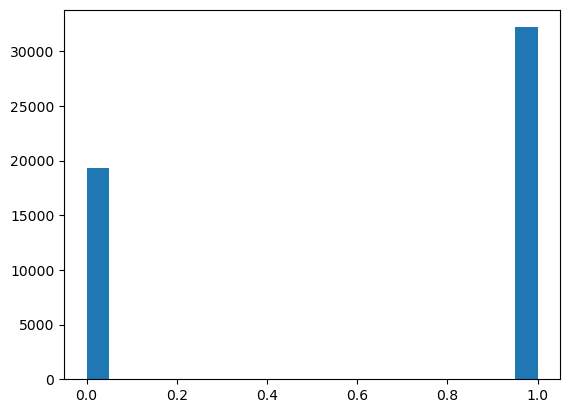

In [6]:
plt.hist(df_train['label'],bins=20);

In [7]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [8]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 2
model = BertClassifier()
LR = 1e-5
              
train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 25751/25751 [57:48<00:00,  7.42it/s]


Epochs: 1 | Train Loss:  0.057                 | Train Accuracy:  0.958                 | Val Loss:  0.033                 | Val Accuracy:  0.976


100%|██████████| 25751/25751 [57:28<00:00,  7.47it/s]


Epochs: 2 | Train Loss:  0.024                 | Train Accuracy:  0.983                 | Val Loss:  0.032                 | Val Accuracy:  0.981


In [10]:
model.parameters

<bound method Module.parameters of BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
text='''Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article, "Paris bans driving due to smog," by Robert Duffer says, how Paris, after days of nearrecord pollution, enforced a partial driving ban to clear the air of the global city. It also says, how on Monday, motorist with evennumbered license plates were ordered to leave their cars at home or be fined a 22euro fine 31. The same order would be applied to oddnumbered plates the following day. Cars are the reason for polluting entire cities like Paris. This shows how bad cars can be because, of all the pollution that they can cause to an entire city.

Likewise, in the article, "Carfree day is spinning into a big hit in Bogota," by Andrew Selsky says, how programs that's set to spread to other countries, millions of Columbians hiked, biked, skated, or took the bus to work during a carfree day, leaving streets of this capital city eerily devoid of traffic jams. It was the third straight year cars have been banned with only buses and taxis permitted for the Day Without Cars in the capital city of 7 million. People like the idea of having carfree days because, it allows them to lesson the pollution that cars put out of their exhaust from people driving all the time. The article also tells how parks and sports centers have bustled throughout the city uneven, pitted sidewalks have been replaced by broad, smooth sidewalks rushhour restrictions have dramatically cut traffic and new restaurants and upscale shopping districts have cropped up. Having no cars has been good for the country of Columbia because, it has aloud them to repair things that have needed repairs for a long time, traffic jams have gone down, and restaurants and shopping districts have popped up, all due to the fact of having less cars around.

In conclusion, the use of less cars and having carfree days, have had a big impact on the environment of cities because, it is cutting down the air pollution that the cars have majorly polluted, it has aloud countries like Columbia to repair sidewalks, and cut down traffic jams. Limiting the use of cars would be a good thing for America. So we should limit the use of cars by maybe riding a bike, or maybe walking somewhere that isn't that far from you and doesn't need the use of a car to get you there. To me, limiting the use of cars might be a good thing to do.'''
out=tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
output = smodel(out['input_ids'].to('cuda'),out['attention_mask'].to('cuda'))
output

tensor([[6.4281, 0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)

In [14]:
float(output[0,1])

10.149016380310059

In [9]:
torch.save(model,'saved_model_2epo.pth')

In [10]:
smodel =torch.load('saved_model_2epo.pth')

In [17]:
smodel.parameters

<bound method Module.parameters of BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor